In [1]:
import ribosomesimulator
import translation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h1>Analyses of the sampling process</h1>
<p>This notebook contains analyses of different aspects of the tRNA sampling process.</p>
<ul>
    <li><a href='#class_importance'>Importance of the tRNA classes for the duration of the sampling process</a></li>
    <li><a href='#processing_times'>Average tRNA processing times</a></li>
    <li><a href='#rejection_rates'>Average tRNA rejection rates</a></li>
    <li><a href='#A_site_access'>Frequency of A-site access</a></li>
</ul>

<a id='class_importance'></a>
<h2>Importance of the tRNA classes for the duration of the sampling process</h2>
<p>Because the different tRNA classes occur with different frequencies and are processed with different rate constants, they contribute differently to the overall duration of the decoding process. This section compares results from model runs with different classes of tRNAs included or excluded.</p>

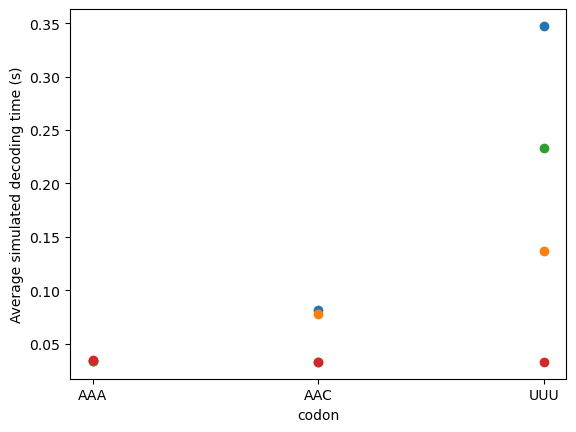

In [2]:
sim = ribosomesimulator.ribosomesimulator()
parsets = ['Scer_concentrations.csv','Scer_concentrations_no_wobble.csv',\
            'Scer_concentrations_no_near.csv','Scer_concentrations_no_wobble_no_near.csv']
codons = ['AAA','AAC','UUU']
labels = ['Full model','no wobble dynamics','no near cognate dyamics','no wobble or \n near cognate dynamics']

results = [[],[],[]]
for idx, codon in enumerate(codons):
    for parset in parsets:
        sim.loadConcentrations('Data/' + parset)
        sim.setCodonForSimulation(codon)
        results[idx].append(sim.run_repeatedly_get_average_time(1000))
results = np.transpose(np.array(results))

fig,ax = plt.subplots()
for idx,set in enumerate(results):
    ax.scatter([0,1,2],set)
ax.set_ylabel('Average simulated decoding time (s)')
ax.set_xticks([0,1,2])
ax.set_xticklabels(codons)
ax.set_xlabel('codon')
plt.savefig('Figure files/Effect of near and wobble cognates.svg')
plt.show()

<a id='processing_times'></a>
<h2>Average processing times for the different tRNA classes</h2>
<p>All tRNAs are processed with the same rection scheme, but with different rate constants. This section isolates the processing times (the time between A-site entry and exit) for the different tRNA classes.</p>

In [3]:
def evaluate_processing_times(codon,codon_type='c'):
    import ribosomesimulator
    import numpy as np
    #set up and run a codon simulator
    sim = ribosomesimulator.ribosomesimulator()
    props = sim.getPropensities()
    props['wobble6f'] = 130
    props['wobblediss'] = 90
    sim.setPropensities(props)
    sim.loadConcentrations('Data/dummy_concentrations.csv')
    sim.setCodonForSimulation(codon)
    sim.run_and_get_times()
    zero_idx = [idx for idx,val in enumerate(sim.ribosome_state_history) if val == 0]
    if codon_type == 'c':
        #for cognate codons only get the time difference between the
        #last zero state and completion of the decoding cycle, which
        #is a 'true' decoding event ie do not count encounter complex decay
        processing_time = np.sum(sim.dt_history[zero_idx[-1]:])
    elif codon_type == 'nc':
        #for near-cognates get the time difference between the
        #zero states, if the distance between zero states is > 2
        #ie simple encounter complex decay is not counted as for cognates
        processing_time = [np.sum(sim.dt_history[zero_idx[n]:zero_idx[n+1]])\
                          for n,val in enumerate(zero_idx[:-2]) if zero_idx[n+1] \
                           - zero_idx[n] > 2]
    else:
        #for non-cognates record times elapsed between zero states up until a
        # cognate enters the ribosome
        processing_time = [np.sum(sim.dt_history[zero_idx[n]:zero_idx[n+1]])\
                          for n,val in enumerate(zero_idx[:-4])]
    return processing_time

In [4]:
#evaluate WC cognate processing times
WC_processing_times = []
for n in range(1000):
    WC_processing_times.append(evaluate_processing_times('AAA'))

In [5]:
#evaluate wobble cognate processing times
wob_processing_times = []
for n in range(1000):
    wob_processing_times.append(evaluate_processing_times('AAC'))

In [6]:
#evaluate near cognate processing times
nc_processing_times = []
for n in range(5):
    nc_processing_times += evaluate_processing_times('AAG',codon_type = 'nc')

In [7]:
non_processing_times = []
for n in range(20):
    non_processing_times += evaluate_processing_times('AAU',codon_type = 'non')

/tmp/ipykernel_18371/885828578.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


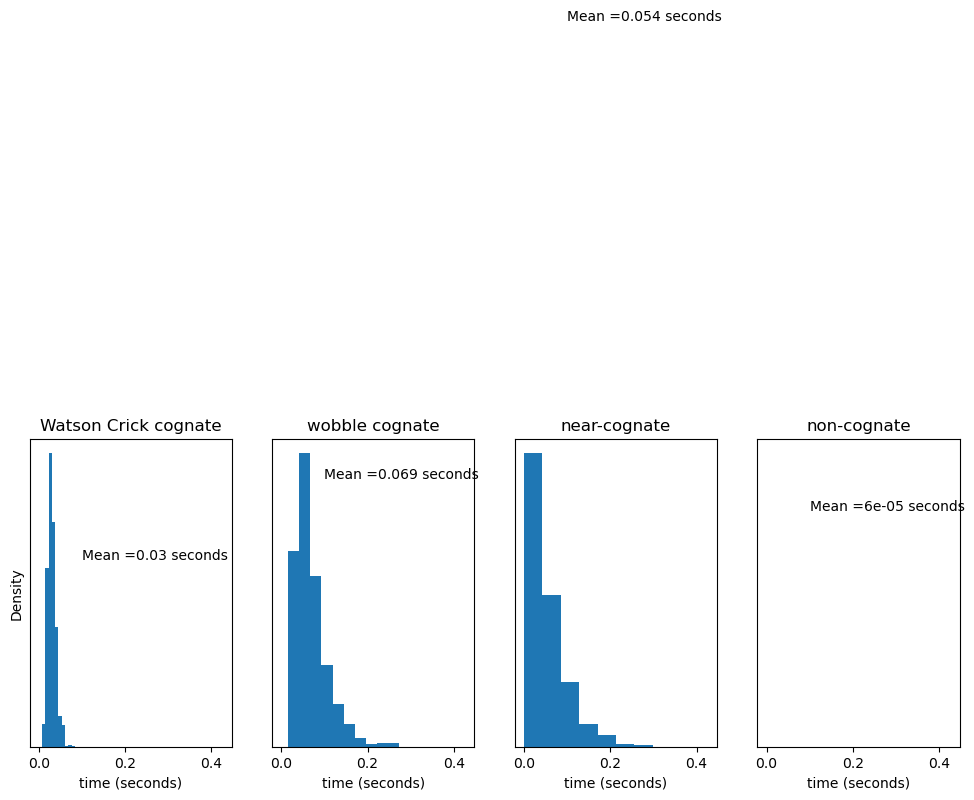

In [8]:
#plot processing times
fig, ax = plt.subplots(1,4, figsize = (12,4), sharex = True)
ax[0].hist(WC_processing_times)
ax[0].text(0.1,210,('Mean ='+"{0:.2g}".format(np.mean(WC_processing_times)) + ' seconds'))
ax[0].set_xlabel('time (seconds)')
ax[0].set_yticks([])
ax[0].set_ylabel('Density')
ax[0].set_title('Watson Crick cognate')
ax[1].hist(wob_processing_times)
ax[1].text(0.1,325,('Mean ='+"{0:.2g}".format(np.mean(wob_processing_times)) + ' seconds'))
ax[1].set_xlabel('time (seconds)')
ax[1].set_yticks([])
ax[1].set_title('wobble cognate')
ax[2].hist(nc_processing_times)
ax[2].text(0.1,4300,('Mean ='+"{0:.2g}".format(np.mean(nc_processing_times)) + ' seconds'))
ax[2].set_xlabel('time (seconds)')
ax[2].set_yticks([])
ax[2].set_title('near-cognate')
ax[3].hist(non_processing_times)
ax[3].text(0.1,820,('Mean ='+"{0:.2g}".format(np.mean(non_processing_times)) + ' seconds'))
ax[3].set_xlabel('time (seconds)')
ax[3].set_yticks([])
ax[3].set_title('non-cognate')
plt.tight_layout()
#plt.savefig('Data/processing times.svg')
plt.show()

<a id='rejection_rates'></a>
<h2>tRNA rejection rates</h2>
<p>The outcome of an individual tRNA sampling event can be acceptance and aminoacyl transfer, or rejection. This section analyses rejection rates for the different tRNAs classes based on the ribosomesimulator.</p>

In [9]:
#count the number of proofreading rejections
sim = ribosomesimulator.ribosomesimulator()
props = sim.getPropensities()
props['wobble6f'] = 130
props['wobblediss'] = 90
sim.setPropensities(props)
sim.loadConcentrations('Data/dummy_concentrations.csv')

repeats = 1000

WC_rejects = 0
sim.setCodonForSimulation('AAA') # WC cognate
for n in range(repeats):
    sim.run_and_get_times()
    states = sim.ribosome_state_history
    rejects = [1 for idx in range(len(states)) if (states[idx] == 20 and states[idx+1] == 0)]
    WC_rejects += np.sum(rejects)
WC_rejection_rate = WC_rejects / (WC_rejects + repeats)
    
wob_rejects = 0
sim.setCodonForSimulation('AAC') # wobble cognate
for n in range(repeats):
    sim.run_and_get_times()
    states = sim.ribosome_state_history
    rejects = [1 for idx in range(len(states)) if (states[idx] == 13 and states[idx+1] == 0)]
    wob_rejects += np.sum(rejects)
wob_rejection_rate = wob_rejects / (wob_rejects + repeats)

near_rejects = 0
sim.setCodonForSimulation('AAG') # near cognate
for n in range(repeats):
    sim.run_and_get_times()
    states = sim.ribosome_state_history
    rejects = [1 for idx in range(len(states)) if (states[idx] == 6 and states[idx+1] == 0)]
    near_rejects += np.sum(rejects)
near_rejection_rate = near_rejects / (near_rejects + repeats)

In [10]:
print(WC_rejection_rate,wob_rejection_rate,near_rejection_rate)

0.06279287722586692 0.4318181818181818 0.9477014800481146


<a id='A_site_access'></a>
<h2>Frequency of A-site access</h2>
<p>The duration of decoding events is determined by how many tRNAs need to be sampled before a cognate tRNA is accepted on average, as well as of what class the sampled tRNAs are. This section plots average access frequencies and dwell times for the different tRNA classes for specified codons.</p>

In [11]:
def analyse_decoding_pattern(codon, repeats = 1000):
    import ribosomesimulator
    import numpy as np

    #set up the simulator
    sim = ribosomesimulator.ribosomesimulator()
    props = sim.getPropensities()
    props['wobble6f'] = 130
    props['wobblediss'] = 90
    sim.setPropensities(props)
    sim.loadConcentrations('Data/Scer_concentrations.csv')
    sim.setCodonForSimulation(codon)


    classes = ['non','near','wob','WC'] # not used, for ifnormatin only
    entry_states = [1,2,9,16] # the reaction state adopted when the above classes enter a ribosome

    accesses_list = []
    times_list = []

    for n in range(repeats):
        #execute a new simulation
        sim.run_and_get_times()

        #collect the number of accesses for each tRNA class
        accesses = {1:0,2:0,9:0,16:0}
        for state in entry_states:
            #count how often each tRNA class accesses the A-site
            accesses[state] = sim.ribosome_state_history.count(state)
        #assess for how much time each tRNA class resided in the A-site
        accesses_list.append(list(accesses.values()))

        #collect the times each class spent in the ribosome
        times = {1:0,2:0,9:0,16:0}
        for idx,state in enumerate(sim.ribosome_state_history):
            if state in entry_states:
                tidx = idx
                this_dwell_time = 0
                l = len(sim.ribosome_state_history)
                while (sim.ribosome_state_history[tidx] != 0) and (sim.ribosome_state_history[tidx] != 21):
                    this_dwell_time += sim.dt_history[tidx + 1]
                    tidx += 1
                times[state] += this_dwell_time
        times_list.append(list(times.values()))
    
    #convert the data lits into numpy arrays
    times_array = np.array(times_list)
    accesses_array = np.array(accesses_list)
    return [list(times_array.mean(axis=0)), list(accesses_array.mean(axis=0))]

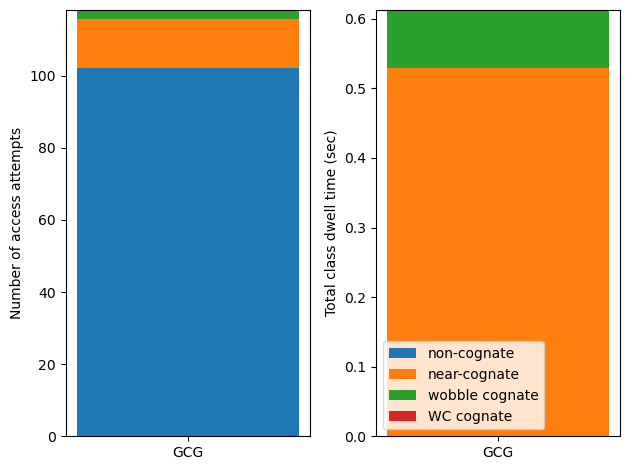

In [12]:
codon = 'GCG'
times, accesses = analyse_decoding_pattern(codon,repeats=1000)

fig,ax = plt.subplots(1,2)
bottom = 0
species = ['non-cognate', 'near-cognate', 'wobble cognate', 'WC cognate']
bottom = 0
for idx,access in enumerate(accesses):
    p1 = ax[0].bar(codon, access, label=species[idx], bottom=bottom)
    bottom += access
ax[0].set_ylabel('Number of access attempts')
bottom = 0
for idx,time in enumerate(times):
    p2 = ax[1].bar(codon, time, label=species[idx], bottom=bottom)
    bottom += time
ax[1].set_ylabel('Total class dwell time (sec)')
plt.tight_layout()
plt.legend()
#plt.savefig('Figure files/' + codon + ' decoding analysis.svg')
plt.show()